In [143]:
from __future__ import absolute_import, division, print_function

import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro
from pyro.contrib.gp.util import Parameterized
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
from pyro.params import param_with_module_name
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
pyro.clear_param_store()
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy
import math
import cProfile
import time
torch.manual_seed(101)
pyro.set_rng_seed(1)

In [144]:
def d_euclidean(a,b):
    """Returns euclidean distance between vectors a and b"""

    return math.sqrt(sum([ (x - y)**2 for (x,y) in zip (a,b) ]))
def rank_matrix(x):
    """Returns rank matrix from pairwise distance matrix a"""
    
    m = x.argsort()
    r = numpy.zeros(x.shape)

    vectors = x.shape[0]

    for i in range(vectors):
        for j in range(vectors):
            pos = numpy.where(m[i,:]==j)
            r[i,j] = pos[0][0] # there should be a better syntax for this
        
    return r.astype('int')


def centering(x):
    """Center matrix x to origo"""
    return x - x.mean(axis=0)


def double_centering(x):
    """Double center matrix x"""
    pass

def distance_matrix(x, distf=None):
    """Returns distance matrix of pairwise distances between vectors
    stored in array a

    distf is function used to calculate distance between vectors,
    if None, euclidean distance is used
    """

    if distf == None:
        distf = d_euclidean

    vectors = x.shape[0]
    d = numpy.zeros([vectors, vectors])

    for i in range(vectors):
        for j in range(i,vectors):
            dd = distf(x[i,:], x[j,:])
            d[i,j] = dd
            d[j,i] = dd

    return d
def moved_out(nn_orig, nn_proj, i, k):
    """Determine points that were neighbours in the original space,
    but are not neighbours in the projection space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for 'moved out' values 
    """

    oo = list(nn_orig[i, 1:k+1])
    pp = list(nn_proj[i, 1:k+1])

    for j in pp:
        if (j in pp) and (j in oo):
            oo.remove(j)

    return oo
def moved_in(nn_orig, nn_proj, i, k):
    """Determine points that are neighbours in the projection space,
    but were not neighbours in the original space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for points which are 'moved in' to point i
    """

    pp = list(nn_proj[i, 1:k+1])
    oo = list(nn_orig[i, 1:k+1])

    for j in oo:
        if (j in oo) and (j in pp):
            pp.remove(j)

    return pp


def scaling_term(k, n):
    """Term that scales measure between zero and one

    k  size of the neighbourhood
    n  number of datapoints
    """

    if k < (n / 2.0):
        return 2.0 / ((n*k)*(2*n - 3*k - 1))
    else:
        return 2.0 / (n * (n - k) * (n - k - 1))


def trustcont_sum(moved, ranks, k):
    """Calculate sum used in trustworthiness or continuity calculation.

    moved

       List of lists of indices for those datapoints that have either
       moved away in (Continuity) or moved in (Trustworthiness)
       projection

    ranks

       Rank matrix of data set. For trustworthiness, ranking is in the
       original space, for continuity, ranking is in the projected
       space.

    k
       size of the neighbournood
    """

    n = ranks.shape[0]
    s = 0

    # todo: weavefy this for speed
    for i in range(n):
        for j in moved[i]:
            s = s + (ranks[i, j] - k)

    a = scaling_term(k, n)

    return 1 - a * s

# Bayesian GPLVM with SVI

We can do dimensional reduction on Iris dataset as follows:  

With Y as the 2D Iris data of shape 150x4 and we want to reduce its dimension to a tensor X of shape 150x2


In [145]:
 y = torch.stack([dist.Normal(4.8, 0.1).sample((150,)),dist.Normal(3.2, 0.3).sample((150,)),dist.Normal(1.5, 0.4).sample((150,)),
 dist.Exponential(0.5).sample((150,))])
y.shape

torch.Size([4, 150])

We  put a unit Gaussian prior to the input and approximate its posterior by a multivariate normal distribution with two variational parameters: ``X_loc`` and ``X_scale_tril``.First, define the initial values for X_loc parameter:

In [146]:
X_loc = torch.zeros(150, 2)

Then, define a Gaussian Process model with input X_loc and output y:

In [147]:
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))

Inducing inputs

In [148]:
Xu = torch.zeros(20, 2)  # initial inducing inputs of sparse model

In [149]:
gpmodel = gp.models.SparseGPRegression(X_loc, y, kernel, Xu, noise=torch.tensor(1.))

Finally, wrap gpmodel by GPLVM, optimize, and get the "learned" mean of X:

In [150]:
gplvm = gp.models.GPLVM(gpmodel)

CPU+SystemTime:51.984375 seconds
Code Run Time:34.940396785736084 seconds


Text(0.5,1,'Convergence of SVI')

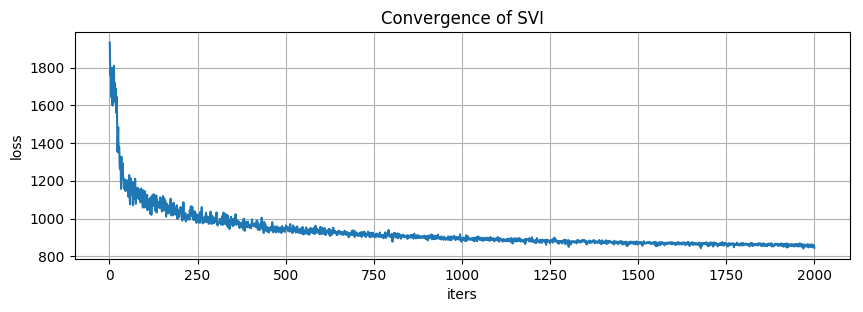

In [151]:
#pyro.optim.Adam({'lr': 0.2, 'betas': [0.9, 0.99]})
from matplotlib import pyplot

i=list(range(1,2001))
#cProfile.run('gplvm.optimize(num_steps=2000)')
st = time.process_time()
st2 = time.time()
losses = gplvm.optimize(num_steps=2000)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
#pyplot.yscale('log')
pyplot.title('Convergence of SVI')



In [152]:
X = gplvm.get_param("X_loc")
X = X.detach().numpy()

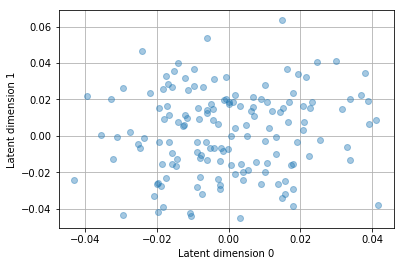

In [153]:
plt.plot(X[:,0],X[:,1],linestyle="",alpha=0.4,marker="o")
pyplot.xlabel('Latent dimension 0')
pyplot.ylabel('Latent dimension 1')
pyplot.grid()


# Reshaping Outputs

In [154]:
Y = numpy.array(y)
Y = Y.T
Y.shape

(150, 4)

# Continuity

In [155]:
dd_orig = distance_matrix(Y)
dd_proj = distance_matrix(X)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

Neearest neighbourboost size k =5 Continuity:0.6065539906103287
Neearest neighbourboost size k =10 Continuity:0.6135960346964064
Neearest neighbourboost size k =20 Continuity:0.6341617852161785
Neearest neighbourboost size k =40 Continuity:0.6699404096834265
Neearest neighbourboost size k =60 Continuity:0.6779140989729224
Neearest neighbourboost size k =75 Continuity:0.6452204204204204


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

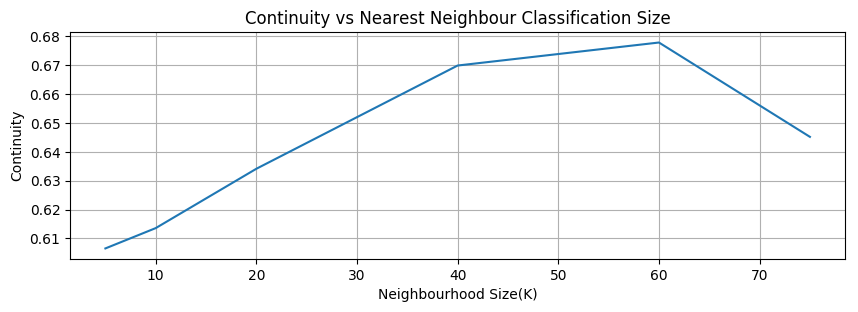

In [156]:
ks=[5,10,20,40,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.grid()
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

# Trust worthiness

In [157]:
ranks_orig =rank_matrix(dd_orig)

Neearest neighbourboost size k =5 Trust:0.6146009389671361
Neearest neighbourboost size k =10 Trust:0.6352912019826518
Neearest neighbourboost size k =20 Trust:0.6558493723849372
Neearest neighbourboost size k =40 Trust:0.6801080074487895
Neearest neighbourboost size k =60 Trust:0.6877422969187675
Neearest neighbourboost size k =75 Trust:0.6477237237237237


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

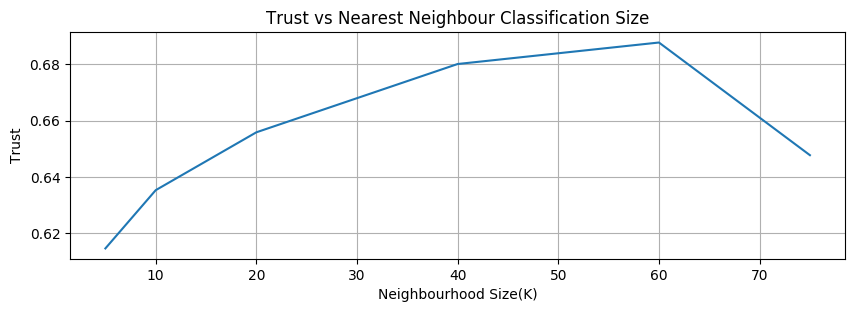

In [158]:
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

#  GPLVM

In [159]:
import GPy
import numpy as np
from matplotlib import pyplot as plt

In [163]:
kernel = GPy.kern.RBF(2, ARD=True)
m = GPy.models.GPLVM(Y, 2,  init="PCA",kernel=kernel)
m.data_labels = Y.argmax(axis=1)

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s02  0003   8.254208e+02   2.365433e+04 
    00s11  0014   4.013044e+02   1.252569e+04 
    00s17  0020  -8.709258e+00   9.615910e+03 
    00s19  0022  -8.709265e+00   2.276139e+04 
    01s20  0219  -3.498226e+02   3.268467e+01 
    05s21  1030  -3.540530e+02   3.834882e-01 
    06s21  1228  -3.541063e+02   9.039620e-01 
    07s21  1416  -3.541193e+02   5.454879e-03 
    07s81  1535  -3.541196e+02   2.484253e-04 
Runtime:     07s81
Optimization status: converged - relative reduction in objective

CPU+SystemTime:37.90625 seconds
Code Run Time:7.826191663742065 seconds


Text(0.5,1,'Loss Function')

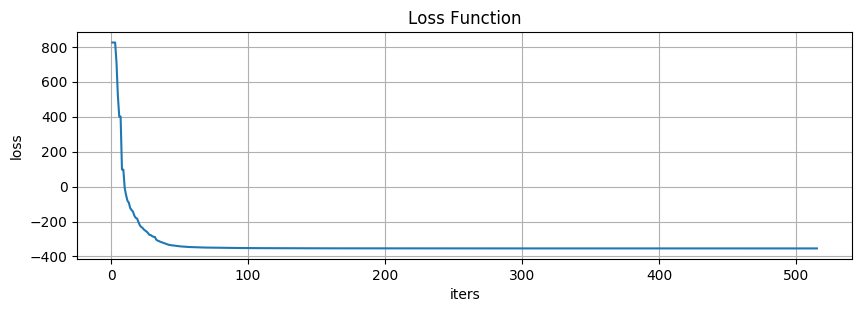

In [164]:
verbose=1
st =  time.process_time()
st2 = time.time()
loss = m.optimize('scg', messages=verbose,max_iters=2000)
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
i=list(range(1,len(loss.trace)+1))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
#pyplot.ylim(-20,40)  # set the ylim to ymin, ymax
pyplot.grid()
pyplot.plot(i,loss.trace)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
#pyplot.yscale('log')
pyplot.title('Loss Function')

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


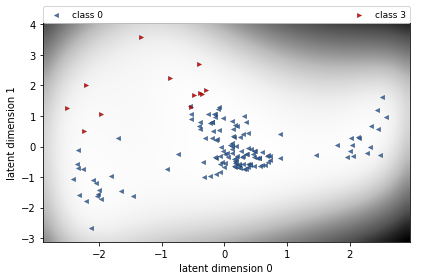

In [165]:
m.plot_latent(labels=m.data_labels)

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


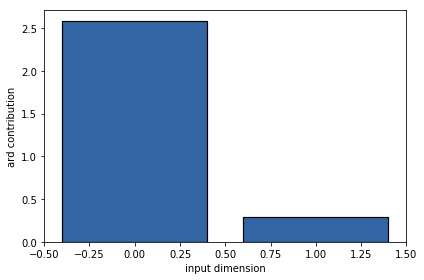

In [166]:
m.kern.plot_ARD()

In [168]:
t = np.array(m.X)
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
cont = []

Neearest neighbourboost size k =5 Continuity:0.9087981220657277
Neearest neighbourboost size k =10 Continuity:0.8978686493184634
Neearest neighbourboost size k =20 Continuity:0.876839609483961
Neearest neighbourboost size k =40 Continuity:0.8369310986964619
Neearest neighbourboost size k =60 Continuity:0.7940056022408963
Neearest neighbourboost size k =75 Continuity:0.7270462462462463


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

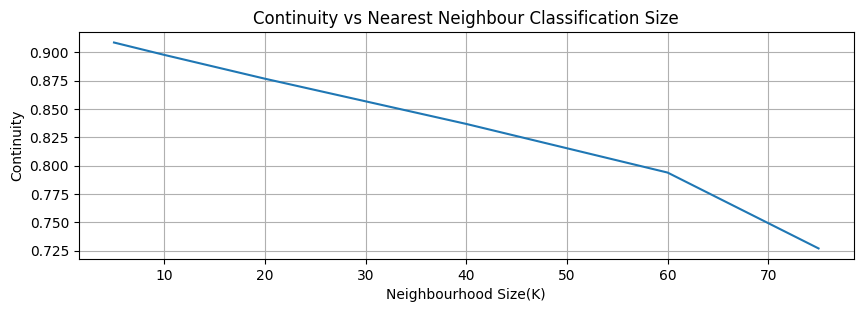

In [169]:
ks=[5,10,20,40,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.grid()
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =5 Trust:0.9655680751173709
Neearest neighbourboost size k =10 Trust:0.9506964064436183
Neearest neighbourboost size k =20 Trust:0.9214839609483961
Neearest neighbourboost size k =40 Trust:0.9216592178770949
Neearest neighbourboost size k =60 Trust:0.9074827264239029
Neearest neighbourboost size k =75 Trust:0.8693501501501502


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

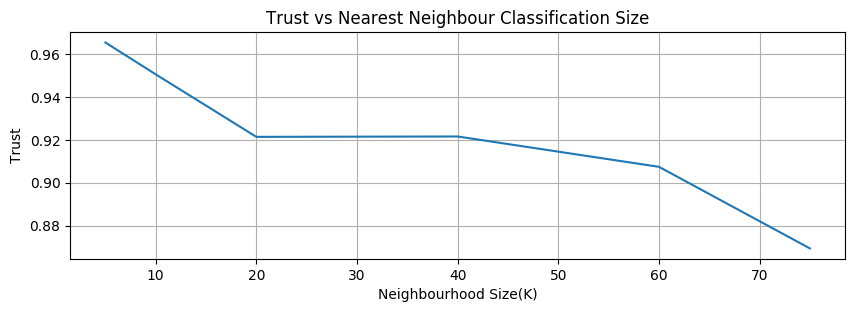

In [46]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

# Bayesian GPLVM

In [170]:
from GPy.models import BayesianGPLVM
from GPy import kern
import numpy as np
import GPy

In [171]:
Q=2
num_inducing=20
m = BayesianGPLVM(Y, Q, num_inducing=num_inducing)

Optimizing model:
Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s14  0004   1.365585e+03   5.429128e+04 
    00s19  0008   1.212251e+03   1.622029e+04 
    01s20  0131   5.244961e+02   1.449470e+02 
    03s21  0374   4.690461e+02   3.329145e+02 

 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add


    05s22  0613   4.629414e+02   3.666124e+01 

 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/psi_comp/rbf_psi_comp.py:131: RuntimeWarning:invalid value encountered in true_divide



    17s27  1944   4.219977e+02   9.092340e+01 
    19s29  2168   4.216608e+02   4.867406e+01 
Runtime:     19s29
Optimization status: converged - relative stepsize

CPU+SystemTime:101.84375 seconds
Code Run Time:19.306236743927002 seconds


 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


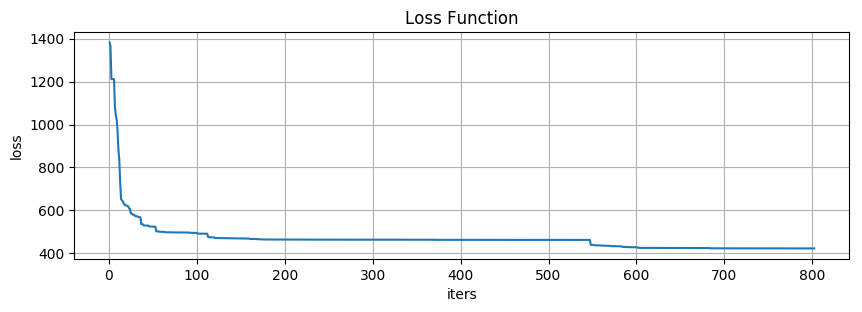

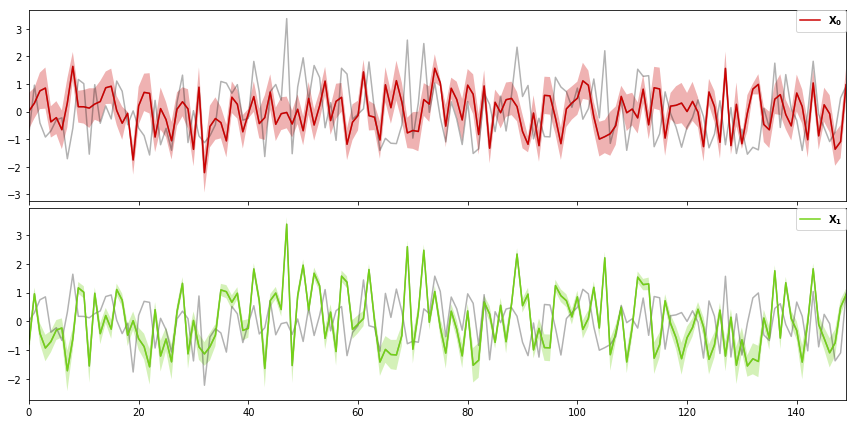

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


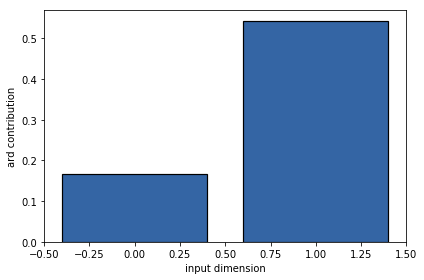

In [172]:
print("Optimizing model:")
max_iters=2000
#bfgs
st =  time.process_time()
st2 = time.time()
loss = m.optimize('scg', messages=1, max_iters=max_iters,gtol=.05)
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
i=list(range(1,len(loss.trace)+1))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
#pyplot.ylim(-20,40)  # set the ylim to ymin, ymax
pyplot.grid()
pyplot.plot(i,loss.trace)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
#pyplot.yscale('log')
pyplot.title('Loss Function')
m.X.plot("BGPLVM Latent Space 1D")
m.kern.plot_ARD()

In [174]:
X0= list(m.X.mean[:,0])
X1= list(m.X.mean[:,1])
t= np.column_stack((X0, X1))
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

Neearest neighbourboost size k =5 Continuity:0.9731455399061033
Neearest neighbourboost size k =10 Continuity:0.9668451053283768
Neearest neighbourboost size k =20 Continuity:0.9576903765690377
Neearest neighbourboost size k =40 Continuity:0.9450502793296089
Neearest neighbourboost size k =60 Continuity:0.9348683473389355
Neearest neighbourboost size k =75 Continuity:0.9146162162162162


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

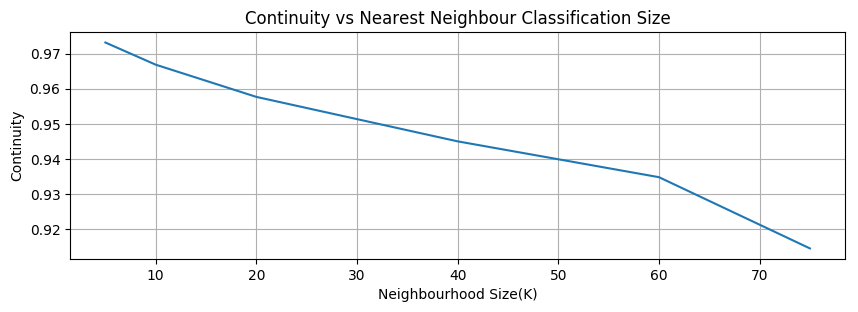

In [175]:
ks=[5,10,20,40,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =5 Trust:0.9647511737089202
Neearest neighbourboost size k =10 Trust:0.9653035935563816
Neearest neighbourboost size k =20 Trust:0.962741980474198
Neearest neighbourboost size k =40 Trust:0.9538454376163873
Neearest neighbourboost size k =60 Trust:0.9422147525676937
Neearest neighbourboost size k =75 Trust:0.9225753753753754


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

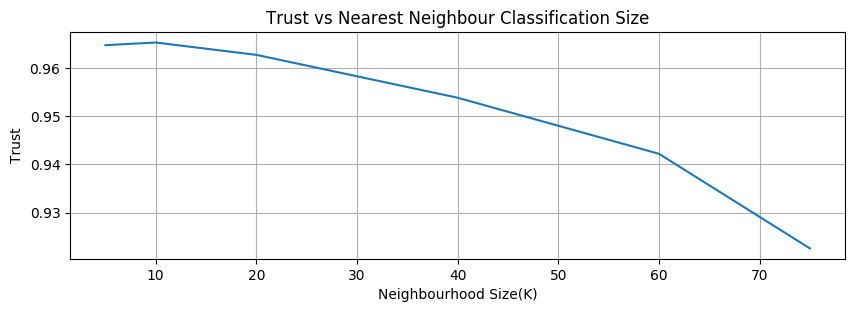

In [176]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

# PCA 

In [177]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(Y)
X = pca.transform(Y)

In [178]:
X.shape

(150, 2)

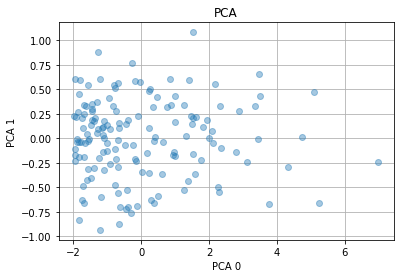

In [179]:
plt.plot(X[:,0],X[:,1],linestyle="",alpha=0.4,marker="o")
pyplot.xlabel('PCA 0')
pyplot.ylabel('PCA 1')
pyplot.title('PCA')
pyplot.grid()

In [180]:
dd_proj = distance_matrix(X)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

Neearest neighbourboost size k =5 Continuity:0.9887981220657277
Neearest neighbourboost size k =10 Continuity:0.9913952912019827
Neearest neighbourboost size k =20 Continuity:0.9929344490934449
Neearest neighbourboost size k =40 Continuity:0.9962607076350093
Neearest neighbourboost size k =60 Continuity:0.9979402427637721
Neearest neighbourboost size k =75 Continuity:0.9982462462462462


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

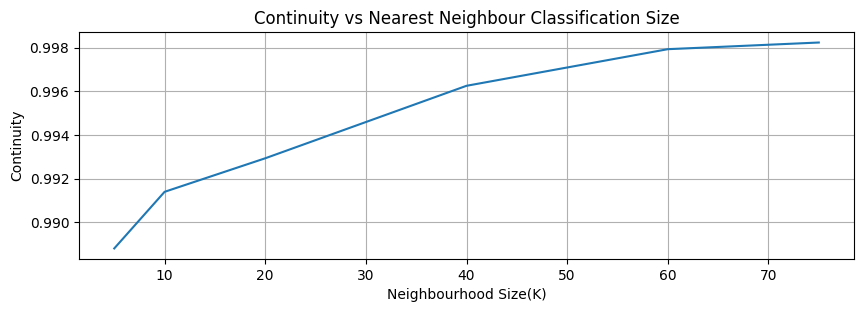

In [181]:
ks=[5,10,20,40,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
#pyplot.yscale('log')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =5 Trust:0.9708169014084507
Neearest neighbourboost size k =10 Trust:0.9757967781908302
Neearest neighbourboost size k =20 Trust:0.9828563458856346
Neearest neighbourboost size k =40 Trust:0.9923500931098697
Neearest neighbourboost size k =60 Trust:0.9954416433239963
Neearest neighbourboost size k =75 Trust:0.9963003003003003


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

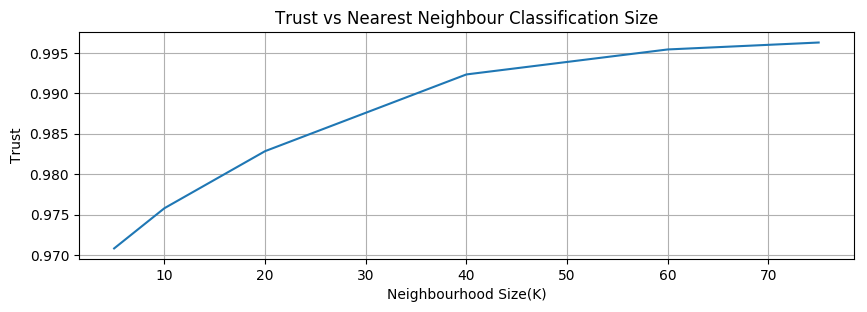

In [67]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(Y.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

# HMC